# Homework 5: Ergodic Control
Due: May 30, 2025

## Preliminaries

Reuse the iLQR code from the previous assignment.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
X0 = np.array([0.3, 0.3])
T = 10  # Time horizon [s]
dt = 0.1  # Time step [s]
N = int(T / dt)  # Number of time steps

# Cost weights
Q = np.diag([0.01, 0.01])
R = np.diag([0.001, 0.001])
Qf = np.diag([1.0, 2.0])

In [ ]:
# Gaussian Mixture Distributions
class GaussianDistribution:
  def __init__(self, omega, mu, sigma):
    self.omega = omega
    self.mu = mu
    self.sigma = sigma

  def pdf(self, x):
    # x: shape (N, 2)
    d = x - self.mu  # shape (N, 2)
    inv_sigma = np.linalg.inv(self.sigma)
    exponent = np.einsum('ni,ij,nj->n', d, inv_sigma, d)
    norm_const = np.sqrt(np.linalg.det(2 * np.pi * self.sigma))
    return self.omega * np.exp(-0.5 * exponent) / norm_const

G1 = GaussianDistribution(
    omega=0.5, mu=np.array([0.35, 0.38]).T,
    sigma=np.array([[0.01, 0.004], [0.004, 0.01]])
)
G2 = GaussianDistribution(
    omega=0.2, mu=np.array([0.68, 0.25]).T,
    sigma=np.array([[0.005, -0.003], [-0.003, 0.005]])
)
G3 = GaussianDistribution(
    omega=0.3, mu=np.array([0.56, 0.64]).T,
    sigma=np.array([[0.008, 0], [0, 0.004]])
)

# Dynamics and linearization
def dynamics(x, u):
  # 2D first-order dynamic system:
  # x_dot(t) = f(x(t), u(t)) = u(t)
  return u

def rollout(x0, U):
    X = np.zeros((N+1, len(x0)))
    X[0] = x0
    for k in range(N):
        X[k+1] = X[k] + dt * dynamics(X[k], U[k])
    return X

def runge_kutta(x0, U):
    X = np.zeros((N+1, len(x0)))
    X[0] = x0
    for k in range(N):
        k1 = dynamics(X[k], U[k])
        k2 = dynamics(X[k] + dt / 2 * k1, U[k])
        k3 = dynamics(X[k] + dt / 2 * k2, U[k])
        k4 = dynamics(X[k] + dt * k3, U[k])
        X[k+1] = X[k] + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
    return X


def linearize(x, u):
    u1 = u[0]
    u2 = u[1]
    A = np.array([[1, 0], [0, 1]])
    B = np.array([[dt, 0], [0, dt]])
    return A, B


def phi(X):
    """
    Given X of shape (M,2), returns Phi of shape (M, K+1, K+1)
    where Phi[m,i,j] = cos(pi*i * X[m,0]) * cos(pi*j * X[m,1])
    """
    # 1) compute φ_k on a quadrature grid
    K = 5           # max frequency in each direction
    M = X.shape[0]
    # X[:,0] → shape (M,1,1), broadcast against i,j
    xv = X[:, 0].reshape(M, 1, 1)
    yv = X[:, 1].reshape(M, 1, 1)
    ix = np.arange(K+1).reshape(1, K+1, 1)
    iy = np.arange(K+1).reshape(1, 1, K+1)
    return np.cos(np.pi*ix*xv) * np.cos(np.pi*iy*yv)

def compute_target_coeffs(rho, grid_size=100):
    # 2) compute c_k^* on a quadrature grid
    # builimport numpy as npd grid points
    lin = np.linspace(0, 1, grid_size)
    Xg, Yg = np.meshgrid(lin, lin)
    XY = np.vstack([Xg.ravel(), Yg.ravel()]).T          # (M,2), M=grid_size^2
    R = rho(XY)                                       # (M,)
    Phi = phi(XY)                                      # (M,K+1,K+1)
    # approximate integral ∫ φ ρ dx ≈ (1/M) Σ φ*ρ
    c_star = (Phi * R[:, None, None]).sum(axis=0) / R.size
    return c_star

# Combine all distributions into a single distribution
def combined_distribution(x):
    return G1.pdf(x) + G2.pdf(x) + G3.pdf(x)

def compute_total_cost(X, U, c_star, R, dt, T):
    """
    X: (N+1,2) trajectory
    U: (N, 2)
    c_star: (K+1, K+1) target coeffs
    R:  control weight matrix (2x2)
    dt: Δt
    T:  total time = N*dt
    """
    # 3) modified cost with ergodic term
    N = U.shape[0]
    K = 5 # max frequency in each direction
    # 3a) control cost
    cost_u = sum(U[k].T @ R @ U[k] for k in range(N)) * dt

    # 3b) ergodic coefficients along X
    Phi_traj = phi(X[:-1])       # (N, K+1, K+1)
    # time-average coefficients
    c_traj = (dt / T) * Phi_traj.sum(axis=0)   # (K+1, K+1)

    # 3c) weight each mode
    # e.g. lambda_k = 1/(1 + kx^2 + ky^2)
    ks = np.arange(K+1)
    ix, iy = np.meshgrid(ks, ks, indexing='ij')
    Lambda = 1.0 / (1.0 + ix**2 + iy**2)

    ergodic_term = np.sum(Lambda * (c_traj - c_star)**2)

    return cost_u + ergodic_term, c_traj

# def compute_total_cost(X, U, traj_desired):
#     cost = 0.0
#     for k in range(N):
#         dx = 2 * (X[k] - traj_desired[k])
#         cost += dx.T @ Q @ dx + U[k].T @ R @ U[k]
#     dx_final = X[-1] - traj_desired[-1]
#     cost += dx_final.T @ Qf @ dx_final
#     return cost

def discrete_ilqr(x0, U_init, traj_desired, max_iter=10):
    # Discrete iLQR with cost history
    U = U_init.copy()
    alpha = 1.0
    cost_history = []
    c_star = compute_target_coeffs(combined_distribution)
    for it in range(max_iter):
        X = rollout(x0, U)
        # X = runge_kutta(x0, U)
        # cost_current = compute_total_cost(X, U, traj_desired)    
        cost_current, c_traj = compute_total_cost(X, U, c_star, R, dt, T)    
        cost_history.append(cost_current)

        # Backward pass
        Vx = 2 * Qf @ (X[-1] - traj_desired[-1])
        Vxx = Qf.copy()
        k_ff = np.zeros_like(U)
        K_fb = np.zeros((N, 2, 2))

        for k in reversed(range(N)):
            A, B = linearize(X[k], U[k])
            dx = X[k] - traj_desired[k]
            qx = 2 * Q @ dx
            qu = 2 * R @ U[k]
            Qx = qx + A.T @ Vx
            Qu = qu + B.T @ Vx
            Qxx = Q + A.T @ Vxx @ A
            Quu = R + B.T @ Vxx @ B
            Qux = B.T @ Vxx @ A

            inv_Quu = np.linalg.inv(Quu)
            k_ff[k] = -inv_Quu @ Qu
            K_fb[k] = -inv_Quu @ Qux
            
            Vx = Qx + K_fb[k].T @ Quu @ k_ff[k] + \
                K_fb[k].T @ Qu + Qux.T @ k_ff[k]
            Vxx = Qxx + K_fb[k].T @ Quu @ K_fb[k] + \
                Qux.T @ K_fb[k] + K_fb[k].T @ Qux

        # Line search
        for _ in range(10):
            X_roll = rollout(x0, U)
            # U_new = U + alpha * k_ff + \
            #     np.einsum('kij,kj->ki', K_fb, (X_roll[:-1] - traj_desired))
            U_new = U + alpha*k_ff + np.einsum('kij,kj->ki', K_fb,
                                               X_roll[:-1] - traj_desired[:-1])
            cost_new, c_traj = compute_total_cost(X, U, c_star, R, dt, T)
            # cost_new = compute_total_cost(rollout(x0, U_new), U_new, traj_desired)
            if cost_new < cost_current:
                break
            alpha *= 0.5

        U = U_new

    X_opt = rollout(x0, U)
    return X_opt, U, cost_history

def ergodic_control(initial_condition, T, deltaTime):
    # Initialize the control input
    U = np.zeros((N, 2))
    # Initialize the state
    x = initial_condition.copy()
    # Loop over the time horizon
    for t in np.arange(0, T, deltaTime):
        # Compute the control input based on the current state
        U[int(t/deltaTime)] = np.array([0.5, 0.5])  # Placeholder control input
        # Update the state based on the dynamics and control input
        x += dynamics(x, U[int(t/deltaTime)]) * deltaTime
    return U



# Problem 1: Ergodic Control of a Gaussian Mixture Distribution
We have a $1\times 1$ search space [meters] and the target spatial distribution as a Gaussian mixture distribution specified as follows:

| Component | Weight $(\omega)$ | Mean $(\mu)$                | Covariance $(\Sigma)$                                                                 |
|-----------|------------------|-----------------------------|---------------------------------------------------------------------------------------|
| 1         | 0.5              | $[0.35,\ 0.38]^T$           | $\begin{bmatrix} 0.01 & 0.004 \\ 0.004 & 0.01 \end{bmatrix}$                          |
| 2         | 0.2              | $[0.68,\ 0.25]^T$           | $\begin{bmatrix} 0.005 & -0.003 \\ -0.003 & 0.005 \end{bmatrix}$                      |
| 3         | 0.3              | $[0.56,\ 0.64]^T$           | $\begin{bmatrix} 0.008 & 0 \\ 0 & 0.004 \end{bmatrix}$                                |

The system is a 2D first-order dynamic system:

$$
\dot{x}(t) = f(x(t), u(t)) = u(t)
$$

with the initial condition $x_0 = [0.3, 0.3]$. Generate an ergodic trajectory with a time horizon of 10 seconds with $\Delta t$ = 0.1s

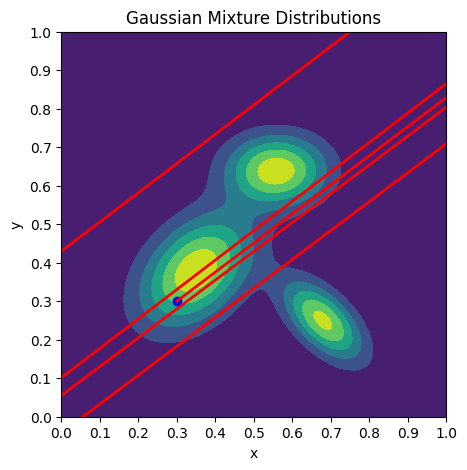

In [ ]:
# Perform Ergodic control from the initial condition over the time horizon
# using the timestep deltaTime
U0 = ergodic_control(X0, T, dt)
desired_trajectory = np.zeros((N+1, 2))
# Create a desired trajectory based on the Gaussian distributions
for k in range(N+1):
    t = k * dt
    desired_trajectory[k, 0] = G1.mu[0] + G2.mu[0] + G3.mu[0]
    desired_trajectory[k, 1] = G1.mu[1] + G2.mu[1] + G3.mu[1]
# Run iLQR to optimize the control input
X_opt, U_opt, cost_hist = discrete_ilqr(X0, U0, desired_trajectory, max_iter=10)
# Extract the trajectory
trajectory = X_opt[:, :2]  # shape (N+1, 2)

# Plotting the Gaussian distributions
fig, ax = plt.subplots(figsize=(5, 5))
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z = combined_distribution(np.array([X.flatten(), Y.flatten()]).T).reshape(X.shape)
ax.contourf(X, Y, Z, levels=6, alpha=1.0, cmap='viridis')
ax.scatter(X0[0], X0[1], color='blue', label='Initial Condition')
# Plot the trajectory
ax.plot(trajectory[:, 0], trajectory[:, 1], color='red', linewidth=2, label='Ergodic Trajectory')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Gaussian Mixture Distributions')
plt.savefig('Gaussian_Mixture_Distributions.png')
plt.show()